In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
data_dir = "data"
train_data_path = os.path.join(data_dir, "train.csv")
test_data_path  = os.path.join(data_dir, "test.csv")
graph_data_path = os.path.join(data_dir, "graph.csv")

In [3]:
# https://gist.github.com/rogerallen/1583593
# ^ Use this in case we need state code translation

from sklearn.preprocessing import StandardScaler

import math
import matplotlib.pyplot as plt
class utils:
    def __init__(self):
        pass
    
    def split(self, dataframe, test=0.2):
        size = dataframe.shape
        train_size = size[0] - math.floor(size[0] * test)
        return dataframe[:train_size], dataframe[train_size:]
    
class CoreData(object):
    def __init__(self, data_path = None, debug=False):
        if not data_path:
            raise Exception("Input file path!")
        self.data_path = data_path
        self.df = None
        self.states = []
        self.state_df = {}
        self.debug = debug
        
    def load(self, normalize=True):
        '''
        DataProcessor.load()
        Pre-load data state-by-state to a dictionary.
        '''
        # Change this line to modify dropped data series.
        dropped_col = ['ID', 'Province_State', 'Date', 'Incident_Rate', 'Recovered', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate' ]
        
        self.df = pd.read_csv(train_data_path)
        self.states = list(np.unique(self.df['Province_State']))
        self.state_df = dict.fromkeys(self.states, None)
        self.mean = dict.fromkeys(self.states, None)
        self.std = dict.fromkeys(self.states, None)
        
        for s in self.states:
            df_filter = self.df['Province_State'] == s
            tmp_state_df = self.df[df_filter]
            self.state_df[s] = tmp_state_df.drop(dropped_col, 1)
            
            # Normalize
            if normalize:
                self.mean[s] = self.state_df[s].mean()
                self.std[s] = self.state_df[s].std()
                self.state_df[s] = (self.state_df[s] - self.mean[s])/self.std[s]
    
    def access(self, state=None):
        if not state:
            raise Exception('Enter state name! i.e. self.access("California")')
        elif state not in self.states:
            raise Exception('Check your spelling of the state.')
        return self.state_df[state]
    
    def access_split(self, state=None, test_portion=0.2):
        df = self.access(state)
        return utils().split(dataframe=df, test=test_portion)


In [4]:
dp = CoreData(train_data_path)

In [5]:
dp.load(False)

# Study Correlation

In [6]:
import seaborn as sns
df = dp.access("Florida")

df.keys()

Index(['Confirmed', 'Deaths', 'Active'], dtype='object')

In [7]:
# sns.pairplot(df)

In [8]:
# dropped_df = df.drop(['Date', 'Hospitalization_Rate','Mortality_Rate','People_Hospitalized', 'Recovered', 'Incident_Rate'], 1)
# sns.pairplot(dropped_df)

In [9]:
t = dp.access_split('California')

In [10]:
import math
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

In [11]:
state = 'California'

In [12]:
training_data, test_data = dp.access_split(state, 0)
data = dp.access(state)

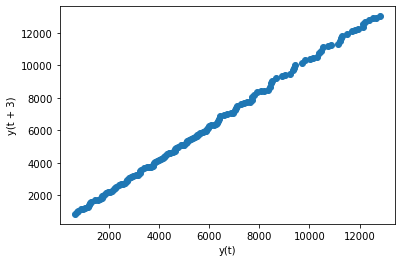

In [13]:
plt.figure()
lag_plot(data['Deaths'], lag=3)
plt.show()

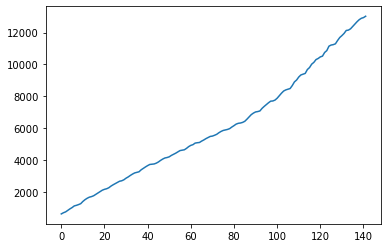

In [14]:
plt.plot(range(len(data['Deaths'])), data['Deaths'])
# plt.xticks(np.arange(0,len(data), len(data)//4), data['Date'][0:len(data):len(data)//4])
plt.show()

[74, 53, 93, 96, 81, 103, 37, 48, 57, 139, 112, 88, 68, 36, 54, 85, 82, 85, 95, 54, 36, 62, 103, 83, 71, 78, 74, 29, 63, 100, 78, 95, 84, 72, 32, 39, 124, 94, 86, 83, 72, 16, 15, 50, 76, 98, 84, 67, 28, 45, 88, 69, 70, 85, 78, 25, 25, 88, 109, 80, 44, 98, 23, 15, 86, 71, 84, 71, 68, 21, 51, 60, 99, 81, 62, 31, 33, 51, 99, 87, 96, 50, 19, 39, 68, 132, 145, 141, 96, 72, 24, 38, 161, 125, 114, 114, 99, 13, 55, 118, 159, 154, 136, 71, 40, 46, 185, 229, 118, 188, 131, 51, 45, 243, 124, 213, 112, 174, 70, 99, 47, 230, 117, 278, 70, 25, 53, 208, 186, 120, 136, 185, 22, 82, 147, 150, 145, 128, 89, 43, 85]


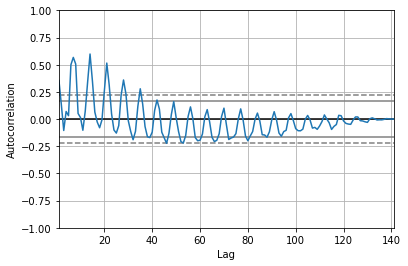

In [15]:
training = training_data['Deaths'].values
testing = test_data['Deaths'].values
temp_data = []
for i in range(1, len(training)):
    temp_data.append(training[i] - training[i-1])
training = temp_data
print(training)
autocorrelation_plot(training)

In [16]:
history = [x for x in training]
model_predictions = []
N_test = 26
print(sum(training) / len(training))

87.81560283687944


In [17]:
len(history)

141

In [18]:
history = [x for x in training]
model_predictions = []
N_test = 26
for time in range(N_test):
    if sum(training) / len(training) > 50:
        model = ARIMA(history, order=(8,2,1))
    else:
        model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    if yhat[0] < 0:
        yhat[0]=0
    model_predictions.append(yhat)
    true_test_value = yhat
    history.append(true_test_value)
M = []
for m in model_predictions:
    M.append(m.tolist()[0])

In [ ]:
print(model_predictions)
print(M)
print(training)

In [ ]:
num_state_train = len(training)
forecast_range = np.arange(num_state_train, num_state_train+26)

plt.figure(figsize=(15, 5))
plt.plot(training)
plt.plot(forecast_range, M)
plt.show()




In [ ]:
training.insert(0, training_data['Deaths'].values[0])
for i in range(1, len(training)):
    training[i] = training[i-1] + training[i]
M[0] = training[-1] + M[0]
for i in range(1, len(M)):
    M[i] = M[i-1] + M[i]
print(training)
print(M)
print(dp.access_split(state, 0)[0])



In [12]:
N_test = 26
keys = ['Deaths', 'Confirmed']
result_death = {}
states = dp.states
for state in states:
    print(f"Processing: {state}...")
    training_data, test_data = dp.access_split(state, 0)
    data = dp.access(state)
    training = training_data['Deaths'].values
    testing = test_data['Deaths'].values
    temp_data = []
    for i in range(1, len(training)):
        temp_data.append(training[i] - training[i-1])
    training = temp_data
    history = [x for x in training]
    model_predictions = []
    print(sum(training) / len(training))
    for time in range(N_test):
        if sum(training) / len(training) > 50:
            model = ARIMA(history, order=(8,2,1))
        else:
            model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        if yhat[0] < 0:
            yhat[0]=0
        model_predictions.append(yhat)
        true_test_value = yhat
        history.append(true_test_value)
    M = []
    for m in model_predictions:
        M.append(m.tolist()[0])
    training.insert(0, training_data['Deaths'].values[0])
    for i in range(1, len(training)):
        training[i] = training[i-1] + training[i]
    M[0] = training[-1] + M[0]
    for i in range(1, len(M)):
        M[i] = M[i-1] + M[i]
    print(f"Done: {state}...{M}")
    
    result_death[state] = M

# N_test = 26
# result_death = {}
# states = dp.states
# for state in states:
#     print(f"Processing: {state}...")
#     training_data, test_data = dp.access_split(state, 0)
#     data = dp.access(state)
#     training = training_data['Deaths'].values
#     testing = test_data['Deaths'].values
#     history = [x for x in training]
#     model_predictions = []
#     for time in range(N_test):
#         model = ARIMA(history, order=(5,1,0))        
#         model_fit = model.fit(disp=0)
#         output = model_fit.forecast()
#         yhat = output[0]
#         #These threadhold may need to be replaced in round2
#         # if yhat[0]-history[-1] < 50 and history[-1]>6000:
#         #     yhat[0] = history[-1]+500
#         model_predictions.append(yhat)
#         true_test_value = yhat
#         history.append(true_test_value)
#     M = []
#     for m in model_predictions:
#         M.append(m.tolist()[0])
#     print(f"Done: {state}...{M}")
    
#     result_death[state] = M

9082827268423, 1567.7340977869696, 1578.7834084565018, 1590.0225577540493]
Processing: New Hampshire...
2.900709219858156
Done: New Hampshire...[432.4597995515388, 433.13744292018185, 433.55270286141916, 433.67366147490213, 433.8298632578832, 434.07858767407384, 434.4168635428832, 434.7272569176699, 434.9515385408874, 435.10839231086754, 435.28509905287865, 435.4849503905547, 435.68692436544774, 435.85567120176654, 435.9930825416635, 436.1113359095525, 436.22989311534036, 436.34301010129184, 436.44257556425424, 436.5208519598479, 436.5825936655907, 436.63174063420814, 436.6716634806423, 436.6989937760434, 436.7117205609791, 436.7117205609791]
Processing: New Jersey...
96.41843971631205
Done: New Jersey...[15945.0, 15945.0, 15945.0, 15945.072260394076, 15948.909356603202, 15952.661169574834, 15956.045266523402, 15959.20348295181, 15961.963864132586, 15964.473821183154, 15967.536653978956, 15971.2789553695, 15975.682163512178, 15980.622095654711, 15985.764191955888, 15991.12770340825, 15

In [11]:
N_test = 26
result_confirmed = {}
states = dp.states
for state in states:
    print(f"Processing: {state}...")
    training_data, test_data = dp.access_split(state, 0)
    data = dp.access(state)
    training = training_data['Confirmed'].values
    testing = test_data['Confirmed'].values
    history = [x for x in training]
    model_predictions = []
    for time in range(N_test):
        model = ARIMA(history, order=(5,1,0))        
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        # These threadhold may need to be replaced in round2
        # if 200 < yhat[0]-history[-1] < 300 and history[-1]>6000:
        #     yhat[0] = history[-1]+500
        # el
        if 500 < yhat[0]-history[-1] < 700 and history[-1]>6000:
            yhat[0] = history[-1]+700
        elif yhat[0]-history[-1] > 3000:
            yhat[0] = history[-1]+3000
        model_predictions.append(yhat)
        true_test_value = yhat
        history.append(true_test_value)
    M = []
    for m in model_predictions:
        M.append(m.tolist()[0])
    print(f"Done: {state}...{M}")
    
    result_confirmed[state] = M

64, 268124.1017510257, 269783.19757013576, 271436.1369785347, 273083.413793284, 274725.19723586185, 276361.81442207063, 277993.61131315277, 279620.71408993704, 281243.39174987783]
Processing: Indiana...
Done: Indiana...[95113.79165104654, 95955.58595967253, 96855.99907561747, 97701.24435700035, 98539.8966156828, 99372.85939316619, 100181.91184270954, 100995.34385654067, 101791.00999339903, 102579.20140930853, 103359.18360192273, 104128.07536331723, 104891.91983684557, 105646.73533933375, 106395.0107898822, 107136.64278557412, 107871.37987085176, 108600.66333590473, 109323.95114531202, 110041.98971918189, 110754.95524081192, 111462.99728464283, 112166.59832821268, 112866.59832821268, 113566.59832821268, 114266.59832821268]
Processing: Iowa...
Done: Iowa...[66107.48678967175, 67031.89695748732, 67762.08320879318, 68504.0234341908, 69204.0234341908, 69904.0234341908, 70604.0234341908, 71304.0234341908, 72004.0234341908, 72704.0234341908, 73404.0234341908, 74104.0234341908, 74804.023434190

In [16]:
forecastID = [x for x in range(26*50)]
deaths = []
confirmed = []

for i in range(26):
    for s in states:
        print(f"Day {i}/26, {s}")
        confirmed.append(result_confirmed[s][i])
        deaths.append(result_death[s][i])



Day 6/26, Indiana
Day 6/26, Iowa
Day 6/26, Kansas
Day 6/26, Kentucky
Day 6/26, Louisiana
Day 6/26, Maine
Day 6/26, Maryland
Day 6/26, Massachusetts
Day 6/26, Michigan
Day 6/26, Minnesota
Day 6/26, Mississippi
Day 6/26, Missouri
Day 6/26, Montana
Day 6/26, Nebraska
Day 6/26, Nevada
Day 6/26, New Hampshire
Day 6/26, New Jersey
Day 6/26, New Mexico
Day 6/26, New York
Day 6/26, North Carolina
Day 6/26, North Dakota
Day 6/26, Ohio
Day 6/26, Oklahoma
Day 6/26, Oregon
Day 6/26, Pennsylvania
Day 6/26, Rhode Island
Day 6/26, South Carolina
Day 6/26, South Dakota
Day 6/26, Tennessee
Day 6/26, Texas
Day 6/26, Utah
Day 6/26, Vermont
Day 6/26, Virginia
Day 6/26, Washington
Day 6/26, West Virginia
Day 6/26, Wisconsin
Day 6/26, Wyoming
Day 7/26, Alabama
Day 7/26, Alaska
Day 7/26, Arizona
Day 7/26, Arkansas
Day 7/26, California
Day 7/26, Colorado
Day 7/26, Connecticut
Day 7/26, Delaware
Day 7/26, Florida
Day 7/26, Georgia
Day 7/26, Hawaii
Day 7/26, Idaho
Day 7/26, Illinois
Day 7/26, Indiana
Day 7/26,

In [17]:
final = pd.DataFrame(list(zip(forecastID, confirmed, deaths)), 
               columns =['ForecastID', 'Confirmed', 'Deaths']) 

In [18]:
final.to_csv("submission.csv", index=False)